# Hypotesis 5: Are spoiler reviews considered less helpful by the users?

In [ ]:
import pymongo
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import t
import scipy.stats as stats

In [ ]:
# Connect to MongoDB and select the database
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close()
print(data.shape)

(300639, 11)


In [ ]:
data.head()

,movie,rating,genre,review_date,review_detail,review_id,review_summary,reviewer,spoiler_tag,helpful_upvotes,helpful_total
0,Satanic (2016),2,-,31 March 2019,"Seriously, don't waste yout time, this is a pr...",rw4754736,Mind numbing trash,axh-35735,0,1,3
1,Satanic (2016),2,-,8 August 2018,Dropped out 20 mins in... characters were tota...,rw4274422,To lame to finish,skyking-14,0,1,4
2,Satanic (2016),6,-,24 September 2016,Seeing the ratings on IMDb I wondered why the ...,rw3550183,Not a bad movie and a bit different,mjsreg,0,26,46
3,Satanic (2016),2,-,30 October 2016,"I only did that because 1 is the lowest point,...",rw3571658,I gave it 2 stars!,gothic-fiction,0,9,18
4,Satanic Meat Cleaver Massacre (2017),1,-,2 August 2017,SATANIC MEAT CLEAVER MASSACRE is a dreadful in...,rw3770545,The title's a misnomer,Leofwine_draca,1,8,9


In [ ]:
# review with spoiler
spoiler_reviews = data[data['spoiler_tag'] == 1]['review_detail']
num_spoiler_reviews = print(len((spoiler_reviews)))

#review without spoiler
no_spoiler_reviews = data[data['spoiler_tag'] == 0]['review_detail']
num_no_spoiler_reviews = print(len((no_spoiler_reviews)))


# Divide the elements in "helpful_upvotes" by the elements in "helpful_total"
data['helpfulness_prop'] = data['helpful_upvotes'] / data['helpful_total']



66182
234457


Percentage of helpfulness_prop for reviews with spoilers:21.93%
Percentage of helpfulness_prop for reviews with NO spoilers:78.07%


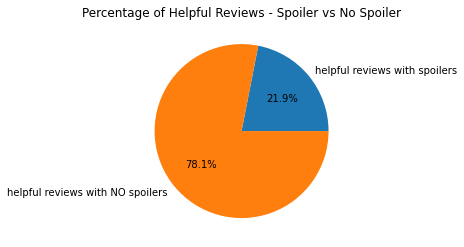

In [ ]:
#operations on helpfulness

# Calculate the sum of "helpfulness_prop" for reviews with spoilers
sum_helpfulness_spoiler = data[data['spoiler_tag'] == 1]['helpfulness_prop'].sum()
sum_helpfulness_NO_spoiler = data[data['spoiler_tag'] == 0]['helpfulness_prop'].sum()

# Calculate the total "helpfulness_prop" across all reviews
total_helpfulness = data['helpfulness_prop'].sum()

# Calculate the percentage of "helpfulness_prop" for reviews with spoilers
percentage_spoiler = (sum_helpfulness_spoiler / total_helpfulness) * 100

# Calculate the percentage of "helpfulness_prop" for reviews with NO spoilers
percentage_NO_spoiler = (sum_helpfulness_NO_spoiler / total_helpfulness) * 100

print("Percentage of helpfulness_prop for reviews with spoilers:%.2f%%" % percentage_spoiler)
print("Percentage of helpfulness_prop for reviews with NO spoilers:%.2f%%" % percentage_NO_spoiler)

#list of the percentages
percentages = [percentage_spoiler, percentage_NO_spoiler]

# Create labels for the pie chart
labels = ['helpful reviews with spoilers', 'helpful reviews with NO spoilers']

# Create the pie chart
plt.pie(percentages, labels=labels, autopct='%1.1f%%')

# Add a title to the pie chart
plt.title('Percentage of Helpful Reviews - Spoiler vs No Spoiler')

# Display the pie chart
plt.show()

Let's use a statistical test to confirm that there is actually a significant association between two categorical variables : presence of spoilers and proportion of helpfulness . If there is an association, it means that the percentages calculated can be considered as legitimate for the two categories.

H0: The presence of spoilers does not have an effect on the proportion of helpfulness in reviews.

H1: The presence of spoilers has an effect on the proportion of helpfulness in reviews.

### CHI-2 TEST OF INDIPENDANCE
In the test we have used two different variables: the "spoiler_tag" column contains binary values indicating whether each review has a spoiler (1) or not (0) and The "helpfulness_prop" column contains the proportion of helpfulness for each review.
We are trying to see if there is actually an association between two variables.


In [ ]:
# Create a contingency table of observed frequencies
contingency_table = pd.crosstab(data['spoiler_tag'], data['helpfulness_prop'])

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the test statistics and p-value
print("Chi-square test statistic:", chi2)
print("P-value:", p)

if p > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis.')

Chi-square test statistic: 6135.997262015637
P-value: 1.9443393728018e-08

Reject the null hypothesis.


With a p-value this low, we must reject the null hypothesis, so it can be said that the two variables are dependent.
The results have to be interpreted cautiously and consider other factors, such as effect size and practical significance.
As an effect size measure we decided to use the Cohen's d.
In this case, we calculated the Cohen's d to quantify the effect size of the difference in helpfulness between reviews with spoilers and reviews without spoilers.

In [ ]:
# Assuming you have two arrays representing the helpfulness proportions for each group
helpfulness_spoiler = data[data['spoiler_tag'] == 1]['helpfulness_prop']
helpfulness_no_spoiler = data[data['spoiler_tag'] == 0]['helpfulness_prop']

# Calculate the means and standard deviations for each group
mean_spoiler = np.mean(helpfulness_spoiler)
mean_no_spoiler = np.mean(helpfulness_no_spoiler)
std_spoiler = np.std(helpfulness_spoiler, ddof=1)  # Use ddof=1 for sample standard deviation
std_no_spoiler = np.std(helpfulness_no_spoiler, ddof=1)

# Calculate the pooled standard deviation
n_spoiler = len(helpfulness_spoiler)
n_no_spoiler = len(helpfulness_no_spoiler)
pooled_std = np.sqrt(((n_spoiler - 1) * std_spoiler**2 + (n_no_spoiler - 1) * std_no_spoiler**2) / (n_spoiler + n_no_spoiler - 2))

# Calculate Cohen's d
cohen_d = (mean_spoiler - mean_no_spoiler) / pooled_std

# Calculate the degrees of freedom for the t-distribution
df = n_spoiler + n_no_spoiler - 2

# Calculate the p-value associated with Cohen's d
p_value = 2 * (1 - t.cdf(np.abs(cohen_d), df))

print("Cohen's d:", cohen_d)
print("p-value:", p_value)

Cohen's d: -0.019275597665809982
p-value: 0.9846212633453699


The Cohen's d coefficient is really small (effect size is small), so there is a difference between the two groups, but the difference is so tiny that it can not be considered relevant in a real case scenario (but in a statistical context yes).